# Evaluate_elevation_for_study_sites_looped

This code uses the 'srtm_dem1sv1_0' DEM dataset (SRTM-derived 1 Second Digital Elevation Models Version 1.0, see http://www.ga.gov.au/metadata-gateway/metadata/record/gcat_72759) to search for signals of palaeovalleys. 

The DEM data is read in, and the palaevalley 2012 shapefile is used to create a mask to separate the region into known mapped palaeovalleys, and the surrounding region. The statistical difference between these two sites is then calculated using a t test and a Kolmogorov-Smirnov test. 

This code is looped, so that all the study sites are analysed, and a comparative bar chart of the statistics is produced. 

Created by Claire Krause, January 2017, Datacube version 1.1.13, Python v3,

** Dependancies in this code: **
- csv file with the lat/lon coordinates of the case study bounding box/es
- palaeovalleys 2012 shape file

** Accompanying code **

An accompanying notebook has been written that demonstrates the outputs from each step of this notebook. Refer to this accompanying notebook for further details of this notebook. 
- Evaluate_elevation_for_study_sites.ipynb

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import datacube
import numpy as np
from datacube.storage import masking
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import os 
import geopandas as gp
import csv

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

def return_good_pixels(nbar, pq):
    """
    This function uses pixel quality information to mask out and remove pixel quality artifacts from extracted data.
    """
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True}
    pqmask = masking.make_mask(pq.pixelquality,  **mask_components)
    return nbar.where(pqmask)

def write_to_csv(OUTPUT_path, row):
    if Studysite.Name == 'Blackwood2A':
        with open(OUTPUT_path,'w') as csvFile:
            writer = csv.writer(csvFile)
            header = ['name', 'ttest', 'KS_test']
            writer.writerow(header)
            writer.writerow(row)
    else:
        with open(OUTPUT_path,'a') as csvFile:
           writer = csv.writer(csvFile)
           writer.writerow(row)

## Import our list of case study sites and accompanying bounding boxes

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Check for statistical difference between known palaeovalleys and outside region

#### NB. Note the reduced resolution from the datacube

This code uses 250 m x 250 m resolution, rather than the native 25 m x 25 m. This is done to make the code more effecient to run, and to minimise memory requirements on the VDI. The resolution can be changed back to 25 m, however the code will be very slow and would require paralellisation to run more quickly. 

In [4]:
dc = datacube.Datacube(app='elevation_analysis')

# Set up the paths to the input and output files
OUTPUT = '/g/data/p25/cek156/elevation_srtm_dem1sv1_0.csv'
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')

# Work out how many sites we want to analyse, and set up a list of numbers we can loop through
x = len(names.index)
iterable = list(range(0,x-6)) 
# NB -6 because we don't have pv polygons for Daintree, Laura or Blackwood1, and we don't want to run the testing site

for num in iterable:
    Studysite = names.ix[num]
    print ('Working on ' + Studysite.Name)
    # Create a bounding box from the locations specified above
    box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
    # Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
    filtered = shp.where(shp.intersects(box)).dropna()
    # Combine all of the relevant polygons into a single polygon
    shp_union = shapely.ops.unary_union(filtered.geometry)

    # Read in the elevation data from the datacube
    query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]),
         'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}
    elev = dc.load(product = 'srtm_dem1sv1_0', group_by='solar_day', **query)
    if elev.any():
        # Create the mask based on our shapefile
        mask = geometry_mask(warp_geometry(shp_union, shp.crs, elev.crs.wkt), elev.geobox, invert=True)
        # Get data only where the mask is 'true'
        data_masked = elev.where(mask)
        # Get data only where the mask is 'false'
        data_maskedF = elev.where(~ mask)
                
        ## Now check for statistical significance
        # Create a new numpy array with just the slope values
        data_masked2 = np.array(data_masked.dem_s)
        data_maskedF2 = np.array(data_maskedF.dem_s)
        # Remove nan values
        data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
        data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
        masked_both = [data_masked_nonan,data_maskedF_nonan]
        if data_masked_nonan.any():
            # How many data points are in each of my NDVI lists?
            size = ([len(i) for i in masked_both])
            # Test with a t-test
            stats_ttest, ttest_pval = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
            # Test with a Kolmogorov-Smirnov test 
            # Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
            stats_KS, KS_pval = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)

            # Write to csv file
            row = [Studysite.Name, stats_ttest, stats_KS]
            # Write our stats to a csv file so we can compare them later
            # If this is the first site, make a new file, otherwise, append the existing file
            print('writing to csv')
            write_to_csv(OUTPUT, row)
            # Or if there is no data...
        else:
            print('no useful elevation data')
            row = [Studysite.Name, 'nan', 'nan']
            write_to_csv(OUTPUT, row)
    # Or if there is no data...
    else:
        print('writing no data to csv')
        row = [Studysite.Name, 'nan', 'nan']
        write_to_csv(OUTPUT, row)

Working on Blackwood2A
writing to csv
Working on Blackwood2B
writing to csv
Working on Blackwood2C
writing to csv
Working on Blackwood2D
writing to csv
Working on GarfordA
writing to csv
Working on GarfordB
writing to csv
Working on Mandora1A
writing to csv
Working on Mandora1B
writing to csv
Working on Mandora1C
writing to csv
Working on Mandora1D
writing to csv
Working on Mandora1E
writing to csv
Working on Mandora1F
writing to csv
Working on Mandora1G
writing to csv
Working on Mandora1H
writing to csv
Working on Mandora1I
writing to csv
Working on Mandora1J
writing to csv
Working on Mandora1K
writing to csv
Working on Mandora1L
writing to csv
Working on Mandora1M
writing to csv
Working on Mandora1N
writing to csv
Working on Mandora1O
writing to csv
Working on Mandora1P
writing to csv
Working on Mandora1Q
writing to csv
Working on Mandora1R
writing to csv
Working on Mandora2A
writing to csv
Working on Mandora2B
writing to csv
Working on Mandora2C
writing to csv
Working on Mandora2D
w

## Combine the smaller regions back into the larger case study areas

We only want one statistic for each larger region, so we need to combine the smaller sub-regions. This is done by averaging the stats for each of the smaller regions. 

In [7]:
study_sites = pandas.read_csv('/g/data/p25/cek156/case_study_sites.csv')
#Read in the CSV with the slope stats
slope_stats = pandas.read_csv(OUTPUT)

mean_values = pandas.DataFrame(columns = ['Site', 'ttest_mean', 'KS_mean'])

exclude_last_three = study_sites[:-3]
for idx, site in enumerate(exclude_last_three.Name):
    ttest_mean = slope_stats[slope_stats.name.str.contains(site)].ttest.mean()
    ks_mean = slope_stats[slope_stats.name.str.contains(site)].KS_test.mean()
    mean_values.loc[idx] = [site, ttest_mean, ks_mean]

print(mean_values)

         Site  ttest_mean   KS_mean
0  Blackwood2 -159.207646  0.449512
1     Garford -135.272455  0.430477
2    Mandora1 -203.541173  0.574719
3    Mandora2 -220.458138  0.525696
4   Murchison -144.194326  0.416061
5         Ord -133.435949  0.561192
6      TiTree  -71.288072  0.269709


## And plot to see what we have!

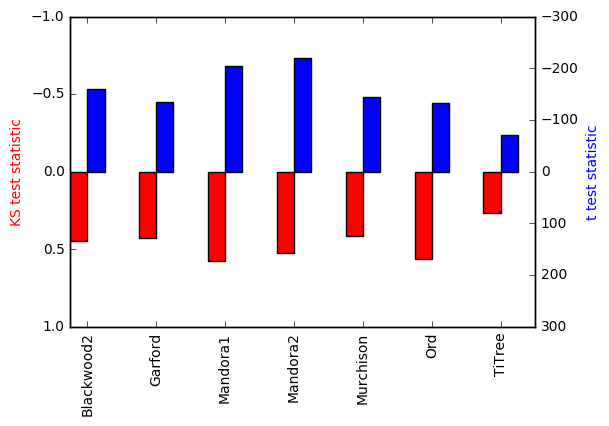

In [10]:
# Setting the positions and width for the bars
pos = list(range(len(mean_values.ttest_mean)))
width = 0.25

# Plotting the bars
#fig, ax = plt.subplots(figsize=(10,5))

fig = plt.figure()

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

#plt.bar(pos, mean_values['KS_mean'], width, color = 'g')
#plt.bar([p + width for p in pos], mean_values['ttest_mean'], width, color = 'r')
mean_values.KS_mean.plot(kind='bar', color='red', ax=ax, width=width, position=1)
mean_values.ttest_mean.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

# Set the y axis label
ax.set_ylabel('KS test statistic', color='red')
ax2.set_ylabel('t test statistic', color='blue')

# Set the position of the x ticks
#ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(mean_values['Site'])

# Setting the x-axis and y-axis limits

ax2.set_ylim([300, -300])
ax.set_ylim([1, -1])

#Let's save the plot
fig.savefig('/g/data/p25/cek156/elevation_srtm_dem1sv1_0_stats.jpg', bbox_inches='tight')